In [2]:
import argparse
import sys
from collections import Counter
import numpy as np 
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = ["#EBCCB7","#C50F36"]
custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_cmap',
    colors=colors,
)

### Generate labels here

In [5]:
labels_df = pd.read_csv('test_texts_NOGROUP.csv', sep='\t')
labels_df = labels_df.dropna()
labels = list()

for index, row in tqdm(labels_df.iterrows()):
    marker1, marker2, marker3 = '<triplet>', '<sub>', '<obj>'
    rp1 = marker1 + '.+?' + marker2
    rp2 = marker2 + '.+?' + marker3
    rp3 = marker3 + '.+?' + marker1
    head_ents = re.findall(rp1, row.triplets)
    tail_ents = re.findall(rp2, row.triplets)
    relations = re.findall(rp3, row.triplets)
    
    head_ents_clean = list()
    tail_ents_clean = list()
    relations_clean = list()
    
    for i in head_ents:
        result = re.search('<triplet>(.*)<sub>', i)
        head_ents_clean.append(result.group(1).strip())
    for i in tail_ents:
        result = re.search('<sub>(.*)<obj>', i)
        tail_ents_clean.append(result.group(1).strip())
    for i in relations:
        result = re.search('<obj>(.*)<triplet>', i)
        relations_clean.append(result.group(1).strip())
        
    len_str = len(row.triplets)
    if len(relations_clean) < len(head_ents_clean):
        work = row.triplets[len_str - 11 :]
        last_rel = work.partition(">")[2]
        relations_clean.append(last_rel.strip())
    
    
    sample = list()
    for i in range(len(head_ents_clean)):
        entry = dict()
        entry['head'] = head_ents_clean[i]
        entry['type'] = relations_clean[i]
        entry['tail'] = tail_ents_clean[i]
        sample.append(entry)
    
    labels.append(sample)
    
    
    
gold_cleaned = []
for i in labels:
    entry = []
    for u in i:
        if not entry:
            entry.append(u)
        elif u not in entry:
            entry.append(u)
           
    gold_cleaned.append(entry)

FileNotFoundError: [Errno 2] No such file or directory: 'test_texts_NOGROUP.csv'

In [4]:
"""could be interesting to see the recall for each relation type """
rt = 'RECEIVES'
gold_cleaned_rt = list()
for i in gold_cleaned:
    sample = list()
    for u in i:
        if u['type'] == rt:
            sample.append(u)
    gold_cleaned_rt.append(sample)

NameError: name 'gold_cleaned' is not defined

### Predictions

In [4]:
predict_df = pd.read_json('predictions_2411_textfinetune.json')

predictions = list()

for index, row in predict_df.iterrows():
    entry = []
    
    if row[0] is not None:
        for each in row[0]:
            entry.append(each)
    if row[1] is not None:
        for each in row[1]:
            entry.append(each)
    if row[2] is not None:
        for each in row[2]:
            entry.append(each)
    
    predictions.append(entry)
    
predictions_cleaned = []
for i in predictions:
    entry = []
    for u in i:
        if not entry:
            entry.append(u)
        elif u not in entry:
            entry.append(u)
           
    predictions_cleaned.append(entry)

## Metric definition

In [5]:
def calculate_metrics(tp, fp, rel):
    precision = 100 * (len(tp) / (len(tp) + len(fp))) 
    recall = 100 * (len(tp) / rel)
    f1score = 2* ( (precision * recall) / (precision + recall) )
    return precision, recall, f1score

In [6]:
def tp_fp_fn_rel(approach, gold, pred):
    
    tp, fp, rel, fn = list(), list(), int(), list()
    
    """tp if whole triplet is correctly predicted"""
    if approach == 'triplet': 
        #calculate tp and fp
        for i in enumerate(pred): 
            
            for u in i[1]:
                if u in gold[i[0]]:
                    tp.append(u)
                else:
                    fp.append(u)
            
            for u in gold[i[0]]:
                rel+=1
                if u not in i[1]:
                    fn.append(u)
            

    """PROBLEM FOR ALL OF THEM"""
    """WE CANNOT COMPARE PER TRIPLET BUT PER ARTICLE"""
    """THEREFORE, ONLY SET-WISE COMPARISON MAKES SENSE"""
    
    
    """tp if head is correctly predicted"""
    if approach == 'head':
        #calculate tp and fp
        for i in enumerate(pred):
            #calculate tp heads for each article
            
            gold_heads = list()
            for u in enumerate(gold[i[0]]):
                gold_heads.append(u[1]['head'])
            gold_heads = set(gold_heads)
            
            preds_sample = list()
            for u in i[1]:
                preds_sample.append(u['head'])
            preds_sample = set(preds_sample)
            
            #check for each article if prediction heads occur in gold heads
            for u in preds_sample:
                if u in gold_heads:
                    tp.append(u)
                else:
                    fp.append(u)
                    
            for u in gold_heads:
                rel +=1
                if u not in preds_sample:
                    fn.append(u)
        
    """tp if tail is correctly predicted"""    
    if approach == 'tail':
        #calculate tp and fp
        for i in enumerate(pred):
            #calculate tp heads for each article
            
            gold_tails = list()
            for u in enumerate(gold[i[0]]):
                gold_tails.append(u[1]['tail'])
            gold_tails = set(gold_tails)
            
            preds_sample = list()
            for u in i[1]:
                preds_sample.append(u['tail'])
            preds_sample = set(preds_sample)
            
            #check for each article if prediction heads occur in gold heads
            for u in preds_sample:
                if u in gold_tails:
                    tp.append(u)
                else:
                    fp.append(u)
                    
            for u in gold_tails:
                rel +=1
                if u not in preds_sample:
                    fn.append(u)
    
    """tp if relation is correctly predicted"""
    if approach == 'relation':
        #calculate tp and fp
        for i in enumerate(pred):
            #calculate tp heads for each article
            
            gold_types = list()
            for u in enumerate(gold[i[0]]):
                gold_types.append(u[1]['type'])
            gold_types = set(gold_types)
            
            preds_sample = list()
            for u in i[1]:
                preds_sample.append(u['type'])
            preds_sample = set(preds_sample)
            
            #check for each article if prediction heads occur in gold heads
            for u in preds_sample:
                if u in gold_types:
                    tp.append(u)
                else:
                    fp.append(u)
                    
            for u in gold_types:
                rel +=1
                if u not in preds_sample:
                    fn.append(u)
    
    return tp, fp, fn, rel

In [7]:
def confusion_matrix(tp, fp, fn, title, tn = 0):
   # sns.set(font_scale=2)
   # cm = np.array([[len(tp), len(fp)], [len(fn), tn]])
   # classes = ['true triplets', 'false triplets']
   # 
   # fig, axs = plt.subplots()
   # plt.subplots_adjust(left=0.2, bottom=0.2)
   # 
   # hm = sns.heatmap(cm, cmap = custom_color_map, annot=True, xticklabels=classes, yticklabels=classes, cbar=False, fmt="d",ax = axs)
   # hm.set(title=title, xlabel="predicted label", ylabel="true label")
   # sns.set_theme(rc = {'figure.figsize':(10,7)})
   # precision, recall, f1score = calculate_metrics(tp, fp, rel)
   # 
   # table = plt.table(cellText=[[round(precision, 1)], [round(recall, 1)], [round(f1score, 1)]], 
   #                 rowLabels=['Precision', 'Recall', 'F1-Score'],
   #                 colLabels=['Value [%]'],
   #                 bbox = ([0.3, -0.6, 0.5, 0.3]))
   # 
   # fig.savefig('test.svg')
   # plt.show()


    sns.set(font_scale=2)
    cm = np.array([[len(tp), len(fn)], [len(fp), tn]])
    classes = ['true triplets', 'false triplets']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(cm, cmap=custom_color_map, annot=True, xticklabels=classes, yticklabels=classes, cbar=False, fmt="d")
    ax.set(title=title, xlabel="predicted label", ylabel="true label")
    fig.savefig('CM_Texts_Triplets_NOGROUP.svg')

METRICS
-------------------------
Precision:  74.89 %
Recall:  82.87 %
F1-Score:  78.68 %


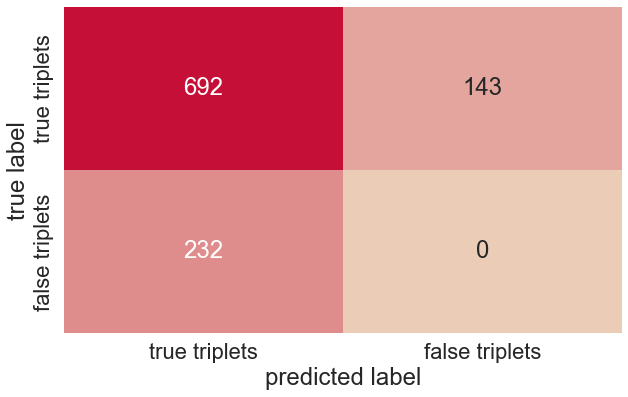

In [9]:
tp, fp, fn, rel = tp_fp_fn_rel('triplet', gold_cleaned, predictions_cleaned)

precision, recall, f1score = calculate_metrics(tp, fp, rel)

#title = "confusion matrix for predictions on text"
confusion_matrix(tp, fp, fn, title = None)

print('METRICS')
print('-------------------------')
print('Precision: ', round(precision, 2), '%')
print('Recall: ', round(recall, 2), '%')
print('F1-Score: ', round(f1score, 2), '%')

# Error Analysis

In [22]:
def error_analysis(approach, gold, pred):
    
    tp, fp, rel, fn, index_fp, index_fn = list(), list(), int(), list(), list(), list()
    
    """tp if whole triplet is correctly predicted"""
    if approach == 'triplet': 
        #calculate tp and fp
        for i in enumerate(pred): 
            for u in i[1]:
                if u in gold[i[0]]:
                    tp.append(u)
                else:
                    fp.append(u)
                    index_fp.append(i[0])
            
            for u in gold[i[0]]:
                rel+=1
                if u not in i[1]:
                    fn.append(u)
                    index_fn.append(i[0])
            

    return fp, index_fp, fn, index_fn

In [31]:
fp_e, index_fp, fn_e, index_fn = error_analysis('triplet', gold_cleaned, predictions_cleaned)

In [29]:
import pandas as pd

new_list = [index_fp, fp_e, index_fn, fn_e]
df = pd.DataFrame(new_list)

writer = pd.ExcelWriter('errors.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='errors_raw', index=False)
writer.save()

In [32]:
len(fp_e)


232

In [33]:
len(fn_e)

143